In [27]:
%matplotlib inline

import sys

import math
import matplotlib.pyplot as plt
import numpy as np

import qiskit.ignis.verification.quantum_volume as qv
import qiskit.tools.jupyter
from qiskit import *
from qiskit.providers.aer.noise.device.models import basic_device_noise_model
from qiskit.transpiler.coupling import CouplingMap
from qiskit.visualization import *

from kamaka import *

In [28]:
np.set_printoptions(threshold=sys.maxsize)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl')

In [56]:
backend = provider.get_backend('ibmq_poughkeepsie')
unitary_sim = BasicAer.get_backend('unitary_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

In [30]:
def find_subgraph(size: int, backend: backend) -> list:
    """Returns a list of integers corresponding to physical qubits forming a connected subgraph
    
    Args:
        size: integer defining the number of nodes that should be in the connected subgraph
        backend: real device backend to form the subgraph on
        
    Returns:
        subgraph: list of integers, each element corresponds to one physical qubit on backend.  
                  list size should be size.
    """
    
    import numpy as np
    
    
    perm = np.random.permutation(list(range(backend.configuration().n_qubits)))
    
    # Setup main graph to traverse
    c_list = backend.configuration().coupling_map
    c_map = CouplingMap(c_list)
    
    while not c_map.subgraph(perm[:size]).is_connected():
        perm = np.random.permutation(list(range(backend.configuration().n_qubits)))
    
    return perm[:size]


In [31]:
# from timeit import default_timer as timer

# start = timer()
# for _ in range(1000):
#     find_subgraph(7, backend)
# end = timer()
# print((end - start)/1000) # Time in seconds, e.g. 5.38091952400282

In [32]:
def ibm_oracle(qc: QuantumCircuit, q: QuantumRegister) -> QuantumCircuit:
    qc.z(q)
    qc.cz(q[1],q[0])
    qc.cz(q[2],q[0])
    qc.cz(q[2],q[1])
    
    return qc

def two_oracle(qc: QuantumCircuit, q: QuantumRegister, winner: int)\
                                                -> QuantumCircuit:
    if winner == 0: 
        qc.ccx(q[0], q[1], q[2])
    elif winner == 1:
        qc.x(q[1])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[1])
    elif winner == 2:
        qc.x(q[0])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[0])
    elif winner == 3:
        qc.x(q[:-1])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[:-1])
    else:
        raise ValueError('Winner must be in range(4)')
    
    return qc

def three_oracle(qc: QuantumCircuit, q: QuantumRegister, winner: int)\
                                                -> QuantumCircuit:
    
    # q[3] is our work space
    if winner == 0: 
        qc.ccx(q[0], q[1], q[3])
    elif winner == 1:
        qc.x(q[1])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[1])
    elif winner == 2:
        qc.x(q[0])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[0])
    elif winner == 3:
        qc.x(q[:-1])
        qc.ccx(q[0], q[1], q[2])
        qc.x(q[:-1])
    else:
        raise ValueError('Winner must be in range(4)')
    
    return qc

def zero_inversion(qc: QuantumCircuit, q: QuantumRegister) -> QuantumCircuit:
    qc.x(q[:2])
    qc.cz(q[0], q[1])
    qc.barrier()
    qc.x(q[:2])
    
    return qc

In [33]:
# # Testing the oracle creator
# circuit_size = 4
# qr, qc = refresh(circuit_size)
# wr = QuantumRegister(circuit_size, 'w')
# qc.add_register(wr)

# add_oracleA(11, qc)

# qc.draw(output='mpl')

In [34]:
# matrix = execute(qc, unitary_sim).result().get_unitary()
# print(cleanup_matrix(trim_matrix(matrix, 2**circuit_size), 1))

In [35]:
# # Testing the inversion about the average

# qc_average = QuantumCircuit(2, name='test')

# qc_average.h(qc_average.qregs[0])
# qc_average = zero_inversion(qc_average, qc_average.qregs[0])
# qc_average.h(qc_average.qregs[0])

# qc_average.draw(output='mpl', plot_barriers=False)

In [36]:
# matrix = execute(qc_average, unitary_sim).result().get_unitary()
# print(cleanup_matrix(matrix, .5))

In [37]:
def ncz(qc: QuantumCircuit, num_controls: int=None, qr: QuantumRegister=None, wr: QuantumRegister=None, uncompute: bool=True) -> QuantumCircuit:
    """ Constructs an n-controlled z gate on a quantum circuit.  Assumes qr[-1] is the target and qr[:-1] are controls.
    
    Params:
        qc: The quantum circuit to operate on.
        num_controls: The number of control bits to implement.
            Defaults to one less than the size of the first quantum register.
        qr: The quantum register holding the n control and 1 target bits. 
            Defaults to the first quantum register in qc
        wr: The quantum register holding the working bits required. Must be >= size(len(qr)-2). 
            Defaults to the second quantum register in qc
        uncompute: If True, then all computations except the target gate are repeated in reverse order.
                    Defaults True.
        
    Returns:
        QuantumCircuit with gates in place.
        
    """
    
    qr = qr if qr is not None else qc.qregs[0]
    try:
        wr = wr if wr is not None else qc.qregs[1]
    except IndexError:
        raise IndexError(f'The circuit provided must have at least 2 quantum registers.\
                         Currently has {len(qc.qregs)}') from None

    n = num_controls if num_controls is not None else len(qr)-1
    if n - 3 > len(wr): raise IndexError('Work register must have at least num_controls-3 qubits')
    if not len(qr) > n: raise IndexError('qr must have at least num_controls+1 qubits')
    if n <= 0: raise ValueError(f'num_controls must be > 0. Given num_controls: {n}')
    
    if n == 1: return qr.cz(q[0], q[1])
    if n == 2: 
        qc.h(q[2])
        qc.ccx(q[0], q[1], q[2])
        qc.h(q[2])
        return qc

    # Phase 1: initial toffoli
    qc.ccx(qr[0], qr[1], wr[0])
    
    # Phase 2: Toffoli descent
    for i in range(n-3):
        qc.ccx(wr[i], qr[i+2], wr[i+1])
    
    # Phase 3: Phase gate
    qc.h(qr[n])
    qc.ccx(wr[n-3], qr[n-1], qr[n])
    qc.h(qr[n])
    
    # Phase 4: Toffoli ascent
    if uncompute:
        for i in range(n-4, -1, -1):
            qc.ccx(wr[i], qr[i+2], wr[i+1])

        qc.ccx(qr[0], qr[1], wr[0])
    
    return qc

In [38]:
def rncz(qc: QuantumCircuit, num_controls: int=None, qr: QuantumRegister=None, wr: QuantumRegister=None, uncompute: bool=True) -> QuantumCircuit:
    """ Constructs an n-controlled z gate on a quantum circuit.  Assumes qr[-1] is the target and qr[:-1] are controls.  Uses
        a simpler construction that can introduce relative phases if not uncomputed.
    
    Params:
        qc: The quantum circuit to operate on.
        num_controls: The number of control bits to implement.
            Defaults to one less than the size of the first quantum register.
        qr: The quantum register holding the n control and 1 target bits. 
            Defaults to the first quantum register in qc
        wr: The quantum register holding the working bits required. Must be >= size(len(qr)-2). 
            Defaults to the second quantum register in qc
        uncompute: If True, then all computations except the target gate are repeated in reverse order.
                    Defaults True.
        
    Returns:
        QuantumCircuit with gates in place.
        
    """
    
    qr = qr if qr is not None else qc.qregs[0]
    try:
        wr = wr if wr is not None else qc.qregs[1]
    except IndexError:
        raise IndexError(f'The circuit provided must have at least 2 quantum registers. Currently has {len(qc.qregs)}') from None
    
    n = num_controls if num_controls is not None else len(qr)-1
    if n - 2 > len(wr): raise IndexError('Work register must have at least num_controls-2 qubits')
    if not len(qr) > n: raise IndexError('qr must have at least num_controls+1 qubits')
    if n < 2: raise ValueError(f'num_controls must be > 1. Given num_controls: {n}')

    # Phase 1: initial toffoli
    qc.rccx(qr[0], qr[1], wr[0])
    
    # Phase 2: Toffoli descent
    for i in range(n-2):
        qc.rccx(wr[i], qr[i+2], wr[i+1])
    
    # Phase 3: Phase gate
    qc.h(qr[n])
    qc.cx(wr[n-2], qr[n])
    qc.h(qr[n])
    
    # Phase 4: Toffoli ascent
    if uncompute:
        for i in range(n-3, -1, -1):
            qc.rccx(wr[i], qr[i+2], wr[i+1])

        qc.rccx(qr[0], qr[1], wr[0])
    
    return qc

In [39]:
# Circuit depth comparison for the various ways to decompose a multi-control phase gate

# First, we generate one of each type: toffoli, phased toffoli, and aqua:
def make_ncz(CIRCUIT_SIZE: int, uncompute: bool=True) -> QuantumCircuit:
    qr, qc = refresh(CIRCUIT_SIZE)
    wr = QuantumRegister(CIRCUIT_SIZE-3, 'w')
    qc.add_register(wr)

    return ncz(qc, uncompute=uncompute)

In [40]:
def make_rncz(CIRCUIT_SIZE: int, uncompute: bool=True) -> QuantumCircuit:    
    qr, qc = refresh(CIRCUIT_SIZE)
    wr = QuantumRegister(CIRCUIT_SIZE-2, 'w')
    qc.add_register(wr)

    return rncz(qc, uncompute=uncompute)

In [41]:
def make_aqua(CIRCUIT_SIZE: int) -> QuantumCircuit:
    qr, qc = refresh(CIRCUIT_SIZE)
    qc.mcrz(math.pi, qr[:-1], qr[-1])
    
    return qc

In [42]:
def add_oracleA(state: str, qc: QuantumCircuit, qr: QuantumRegister=None, wr: QuantumRegister=None) -> QuantumCircuit:
    """Add an ancillary oracle to a quantum circuit with the form -1^f(x) * |x>
    
    Params:
        state: string containing the integer representation of the state for which f(x) should return 1
        qc: QuantumCircuit onto which to add the oracle
        qr: QuantumRegister holding the primary computation.  Defaults to the first register in qc
        wr: Ancillary QuantumRegister holding the multi-control ancillary bits and oracle ancillary bit
            len(wr) must be at least len(qr).  Defaults to the second register in qc.
    
    Returns:
        QuantumCircuit containing the oracle
    
    """
    
    # TODO Change state param to accept a list of acceptable states
    
    qr = qr if qr is not None else qc.qregs[0]
    try:
        wr = wr if wr is not None else qc.qregs[1]
    except IndexError:
        raise IndexError(f'The circuit provided must have at least 2 quantum registers. Currently has {len(qc.qregs)}') from None
    
    if len(qr) > len(wr): raise IndexError('Work register must be the same size as the primary register or larger')
    
    binary_expansion = f'{state:b}'
    if len(binary_expansion) > len(qr): raise IndexError(f'log({state}) is not less than {len(qr)}.')
    
    # NOT the wires where the magic state bit should be 0
    for i in range(len(qr)):
        if not state & (1 << i): # i.e. tharr be zeroes in this here bitstring position
            qc.x(qr[i])
    
    # Establish the necessary oracle state to get the phase in the main register.
    # We use a |1> instead of a |-> gate because we use a Z gate to actually mark our state, and X (Z) X = XH (X) HX
    qc.x(wr[0])
        
    # Our multi-control z gate assumes the entire work register is available for ancillas and that we want our target at qr[-1]
    # So we create some fake registers constructed so we can use this function by swapping our true target qubit into the primary register
    qr._bits.append(wr[0])
    qr.size += 1
    
    wr._bits = wr._bits[1:]
    wr.size -= 1
    
    # Add the actual oracle function by doing a controlled Z across the wires representing the input bitstring
    rncz(qc)
    
    # Now we undo the register changes
    wr._bits.insert(0, qr[-1])
    wr.size += 1
    
    qr._bits = qr._bits[:-1]
    qr.size -= 1
    
    # Undo the state preparation on the oracle bit
    qc.x(wr[0])
    
    # Undo the NOT on wires where the magic state bits should be 0
    for i in range(len(qr)):
        if not state & (1 << i):
            qc.x(qr[i])

In [43]:
# # Test make_rncz()
# CIRCUIT_SIZE = 4

# circ = make_rcnz(CIRCUIT_SIZE, False)
# matrix = execute(circ, unitary_sim).result().get_unitary()

In [44]:
# circ.draw(output='mpl')

In [45]:
# print(cleanup_matrix(matrix, 1))

In [46]:
# Script to compare depths at different circuit sizes

def print_results(results: dict, circuit_sizes: list) -> None:
    # Print header
    table_width = 12 * (2 + len(circuit_sizes)) + 2
    print(f'{"Circuit Depth for an n-controlled gate, by construction method":^{table_width}}\n\n')
    print(f'{"Circ type / n=":<14}', end='')
    
    for size in circuit_sizes:
        print(f'{str(size-1):^12}', end='')
    
    print(f'{"Avg Growth":^12}', end='')
    print('\n')
    
    # Data
    for k in results.keys():
        print(f'{k:^14s}', end='')
        
        for idx, result in enumerate(results[k]):
            ratios = []
            if idx > 0:
                ratio = result/results[k][idx-1]
                ratios.append(ratio)
                print(f'{str(result) + "/" + f"{ratio:1.2f}" + "x":^12}', end='')
            else: print(f'{str(result) + "/1.00x":^12s}', end='')
        
        print(f'{sum(ratios)/len(ratios):^12f}')

    return

def get_depth_data() -> None:
    # Generate data
    circuit_sizes = [x for x in range(4, 16)]
    circuit_types = ['ncz', 'rncz', 'aqua', 'ncz garbage']
    results = {t:[] for t in circuit_types}


    for size in circuit_sizes:
        circuits = []

        # We have to make sure to generate circuits in the same order as circuit_types
        circuits.append(make_ncz(size))
        circuits.append(make_rncz(size))
        circuits.append(make_aqua(size))
        circuits.append(make_ncz(size, False))

        for idx, t in enumerate(circuit_types):
            results[t].append(circuits[idx].decompose().decompose().depth())

    print_results(results, circuit_sizes)

# get_depth_data()

In [97]:
def make_grovers(state:int, size: int, measure: bool=True, loop: int=None) -> QuantumCircuit:
    """ Create and return a quantum circuit implementation of Grover's search algorithm.
    
    Params:
        state: Integer representation of the binary string to be encoded as the magic state.
        size: number of qubits to use in the primary register.  
            Circuit will require at least 2 * size qubits in width, and size must be at
            least log(state) qubits.
        measure: boolean.  If True, then measurements will be added to the circuit.  Default True.
        loop: Integer representing the nuumber of iterations to loop the algorithm.  Defaults to sqrt(N)
    
    """
    qr, qc = refresh(size)
    wr = QuantumRegister(size)
    cr = ClassicalRegister(size, 'm')
    qc.add_register(wr)
    qc.add_register(cr)
    
    qc.h(qr)
    
    loop = loop if loop is not None else math.ceil(math.sqrt(2**size))
    for i in range(loop):
        add_oracleA(state, qc)

        # Inversion about the average
        qc.h(qr)
        qc.x(qr)
        rncz(qc, uncompute=False)
        qc.x(qr)
        qc.h(qr)
    
    if measure: qc.measure(qr, cr)
    
    return qc

In [93]:
circs = []
for i in range(3):
    qc = make_grovers(5, 3, loop=i+1)
    circs.append(qc)

def reg_jobs(circ: tuple,  layouts: dict, job_details: dict) -> list, dict:
    import Date
    
    BATCH_SIZE = 20
    data = layouts
    
    # TODO gotta check this.  I might want configuration() or something else
    backend = provider.get_backend(job_details['backend'])
    backend_details = backend.parameters()
    
    original_circ, state, size = circ
    
    shots = job_details['shots']
    opt_level = job_details['optimization_level']
    size = circ_details
    
    # Get batches
    batches = []
    coupling_maps = [data.keys()]
    while len(coupling_maps) >= BATCH_SIZE:
        batches.append(coupling_maps[:BATCH_SIZE]))
        coupling_maps = coupling_maps[BATCH_SIZE:]
    
    batches.append(coupling_maps)
    
    # Register each circuit in data collection
    
    for each batch in batches:
        for each idx, coupling_map in enumerate(batch):
            compiled_circ = transpile(original_circ, backend, coupling_map=coupling_map, optimization_level=opt_level)
            
            with data[coupling map] as d:
                d['backend'] = backend
                d['job_details'] = job_detais
                d['backend_details'] = backend_details
                d['original_circuit'] = original_circ
                d['compiled_circuit'] = compiled_circ
                d['date'] = Date.date()
                d['depth'] = compiled_circ.decomposed().depth()
                d['state'] = state
                d['size'] = size
                d['index'] = idx
                
        
    return batches, data

def execute_batch(batch, data):
    
    details = next(iter(data.values()))
    job = execute(batch, 
                  details[backend], 
                  shots=details['shots'], 
                  optimization_level=details['optimization_level'])
        
        
    for k in data.keys():
        data[k]['job_id'] = job.job_id()
    
    return data

def get_batch_result(data):
    backend = provider.get_backend(next(iter(data.values()))['backend'])
    
    for each dict in data.values():
        
        # Reduce our requests to the server
        job_id = dict['job_id']
        if job_id in jobs:
            job = jobs[job_id]
        else: 
            jobs[job_id] = job = backend.retrieve_job(dict['job_id'])
        
        # I don't think this will work.  check how to differentiate circuits when retreiving job
        dict['counts'] = job.result().get_count(dict['index']))
        
    return data

# job = execute(circs, backend, shots=2048, optimization_level=2)

In [94]:
from qiskit.tools.monitor import job_monitor

job_monitor(job)
actual = job.result().get_counts()

Job Status: job has successfully run


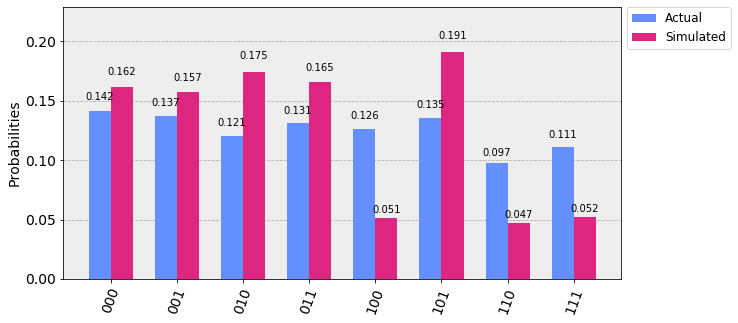

In [95]:
sim = execute(qc, qasm_sim, shots=8192).result().get_counts()

#opt=0, shots=1024, iter=1
previous = backend.retrieve_job('5d6c28171bfc53001925b2b1').result().get_counts()
data = [actual, sim]
plot_histogram(data, legend=['Actual', 'Simulated'], figsize=(10, 5))